In [3]:
# ============================
# Wildfire Random Forest Experiments
# ============================

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import joblib

# ---------------------------
# 1. Load Data
# ---------------------------
df = pd.read_parquet("/content/wildfire_data.parquet")
df.head()
target = "Wildfire"

# Rename columns for consistency
df = df.rename(columns={
    'datetime': 'date',
    'tmmx': 'max_temp',
    'vs': 'wind_speed',
    'fm100': 'fuel_moisture_100h'
})

# Define numeric and categorical features
num_features = ['latitude', 'longitude', 'max_temp', 'wind_speed', 'fuel_moisture_100h']
cat_features = ['rmax_label']

# ---------------------------
# 2. Temporal Split
# ---------------------------
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Define last two years for test set
last_year = df['date'].dt.year.max()
second_last_year = last_year - 1

# Split data
train_df = df[df['date'].dt.year < second_last_year]   # first 8 years
test_df  = df[df['date'].dt.year >= second_last_year]  # last 2 years

# Split into X and y
X_train = train_df[num_features + cat_features + ['date']]
y_train = train_df[target]
X_test = test_df[num_features + cat_features + ['date']]
y_test = test_df[target]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Debug: check columns
print("\nX_train columns:")
print(X_train.columns)
print("\nX_test columns:")
print(X_test.columns)


Train shape: (1374325, 7), Test shape: (90239, 7)

X_train columns:
Index(['latitude', 'longitude', 'max_temp', 'wind_speed', 'fuel_moisture_100h',
       'rmax_label', 'date'],
      dtype='object')

X_test columns:
Index(['latitude', 'longitude', 'max_temp', 'wind_speed', 'fuel_moisture_100h',
       'rmax_label', 'date'],
      dtype='object')


In [7]:
# ============================
# Wildfire Random Forest Experiments with Hyperparameter Tuning
# ============================

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import joblib

# ---------------------------
# 1. Load Data
# ---------------------------
df = pd.read_parquet("/content/wildfire_data.parquet")
target = "Wildfire"

# Rename columns
df = df.rename(columns={
    'datetime': 'date',
    'tmmx': 'max_temp',
    'vs': 'wind_speed',
    'fm100': 'fuel_moisture_100h'
})

# Features
num_features = ['latitude', 'longitude', 'max_temp', 'wind_speed', 'fuel_moisture_100h']
cat_features = ['rmax_label']

# ---------------------------
# 2. Temporal Split
# ---------------------------
df['date'] = pd.to_datetime(df['date'])
last_year = df['date'].dt.year.max()
second_last_year = last_year - 1

train_df = df[df['date'].dt.year < second_last_year]
test_df  = df[df['date'].dt.year >= second_last_year]

X_train = train_df[num_features + cat_features + ['date']]
y_train = train_df[target]
X_test = test_df[num_features + cat_features + ['date']]
y_test = test_df[target]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ---------------------------
# 3. Custom Transformer
# ---------------------------
class TimeFeaturesAdder(BaseEstimator, TransformerMixin):
    """
    Extracts cyclical month and relative year from a datetime column.
    Passes through other numerical features unchanged.
    """
    def __init__(self, datetime_col="date", use_year=True, use_month=True):
        self.datetime_col = datetime_col
        self.use_year = use_year
        self.use_month = use_month
        self.min_year = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        if self.use_year and self.datetime_col in X.columns:
            self.min_year = pd.to_datetime(X[self.datetime_col]).dt.year.min()
        self.non_datetime_features = [col for col in X.columns if col != self.datetime_col]
        return self

    def transform(self, X):
        Xt = X.copy()
        if self.datetime_col not in Xt.columns:
            raise ValueError(f"Datetime column '{self.datetime_col}' not found.")
        dates = pd.to_datetime(Xt[self.datetime_col])
        new_features = []

        if self.use_month:
            months = dates.dt.month
            Xt['month_sin'] = np.sin(2 * np.pi * months / 12)
            Xt['month_cos'] = np.cos(2 * np.pi * months / 12)
            new_features.extend(['month_sin', 'month_cos'])

        if self.use_year:
            years = dates.dt.year
            Xt['years_since_start'] = years - self.min_year
            new_features.append('years_since_start')

        Xt = Xt.drop(columns=[self.datetime_col])
        output_features = self.non_datetime_features + new_features
        self.feature_names_out_ = output_features
        return Xt[output_features]

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_out_ is None:
            raise RuntimeError("fit must be called before get_feature_names_out.")
        return self.feature_names_out_

# ---------------------------
# 4. Experiment Runner with Hyperparameter Tuning
# ---------------------------
def run_experiment(X_train, y_train, X_val, y_val,
                   use_year=True, use_month=True,
                   experiment_name=None, save_model=True,
                   hyperparam_tuning=True):

    if experiment_name is None:
        experiment_name = f"wildfire_exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    print(f"\n🧪 Running experiment: {experiment_name}")
    print(f"  - use_year={use_year}, use_month={use_month}")

    humidity_order = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

    num_pipeline = Pipeline([
        ("time_feats", TimeFeaturesAdder(datetime_col='date', use_year=use_year, use_month=use_month)),
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(categories=[humidity_order]))
    ])

    num_features_with_date = num_features + ['date']
    preprocess = ColumnTransformer([
        ("num", num_pipeline, num_features_with_date),
        ("cat", cat_pipeline, cat_features)
    ])

    pipeline = Pipeline([
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
    ])

    # ---------------------------
    # Hyperparameter Tuning
    # ---------------------------
    if hyperparam_tuning:
        param_grid = {
            'model__n_estimators': [100, 150],        # moderate number of trees
            'model__max_depth': [5, 10],              # limit tree depth
            'model__min_samples_split': [5, 10],  # require more samples to split
            'model__min_samples_leaf': [5, 10],       # require more samples in leaf nodes
            'model__max_features': ['sqrt']            # only use sqrt features per split (safer)
        }


        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grid,
            n_iter=5,
            scoring='roc_auc',
            cv=3,
            verbose=2,
            n_jobs=-1,
            random_state=42
        )

        search.fit(X_train, y_train)
        best_pipeline = search.best_estimator_
        print(f"\n🏆 Best Hyperparameters: {search.best_params_}")
    else:
        best_pipeline = pipeline
        best_pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = best_pipeline.predict(X_val)
    y_proba = best_pipeline.predict_proba(X_val)[:, 1]

    # Metrics
    results = {
        "experiment": experiment_name,
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred),
        "recall": recall_score(y_val, y_pred),
        "roc_auc": roc_auc_score(y_val, y_proba)
    }

    print("\n📊 Evaluation Metrics")
    for k, v in results.items():
        if k != "experiment":
            print(f"{k:>10}: {v:.4f}")

    # Feature importance
    rf_model = best_pipeline.named_steps['model']
    feature_names = best_pipeline.named_steps['preprocess'].get_feature_names_out()
    feat_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10,6))
    plt.barh(feat_importance_df['Feature'][:10], feat_importance_df['Importance'][:10])
    plt.gca().invert_yaxis()
    plt.title(f"Top 10 Features - {experiment_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

    # Save model
    if save_model:
        model_path = f"{experiment_name}.pkl.gz"
        joblib.dump(best_pipeline, model_path, compress=3)
        print(f"💾 Model saved as {model_path}")

    return results, feat_importance_df

# ---------------------------
# 5. Run Multiple Variants
# ---------------------------
experiments = [
    {"use_year": True, "use_month": True, "name": "year_and_month"},
    {"use_year": False, "use_month": True, "name": "month_only"},
    {"use_year": True, "use_month": False, "name": "year_only"},
    {"use_year": False, "use_month": False, "name": "no_time_features"},
]

results_all = []
for exp in experiments:
    res, feat_df = run_experiment(
        X_train, y_train, X_test, y_test,
        use_year=exp["use_year"],
        use_month=exp["use_month"],
        experiment_name=exp["name"],
        hyperparam_tuning=True  # enable hyperparameter tuning
    )
    results_all.append(res)

# ---------------------------
# 6. Compare Results
# ---------------------------
results_df = pd.DataFrame(results_all)
print("\n🏁 Summary of All Experiments")
print(results_df)

plt.figure(figsize=(8,5))
for metric in ["accuracy", "precision", "recall", "roc_auc"]:
    plt.plot(results_df["experiment"], results_df[metric], marker='o', label=metric)
plt.title("Model Performance Across Pipeline Variants")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


Train shape: (1374325, 7), Test shape: (90239, 7)

🧪 Running experiment: year_and_month
  - use_year=True, use_month=True
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



🏆 Best Hyperparameters: {'model__n_estimators': 150, 'model__min_samples_split': 5, 'model__min_samples_leaf': 10, 'model__max_features': 'sqrt', 'model__max_depth': 10}

📊 Evaluation Metrics
  accuracy: 0.6938
 precision: 0.7043
    recall: 0.9357
   roc_auc: 0.6116


NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Train shape: (901000, 7), Test shape: (75376, 7)

🧪 Running experiment: year_and_month
  - use_year=True, use_month=True
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:25:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🏆 Best Hyperparameters: {'model__subsample': 1, 'model__n_estimators': 150, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1}

📊 Evaluation Metrics
  accuracy: 0.7928
 precision: 0.8272
    recall: 0.9376
   roc_auc: 0.6093


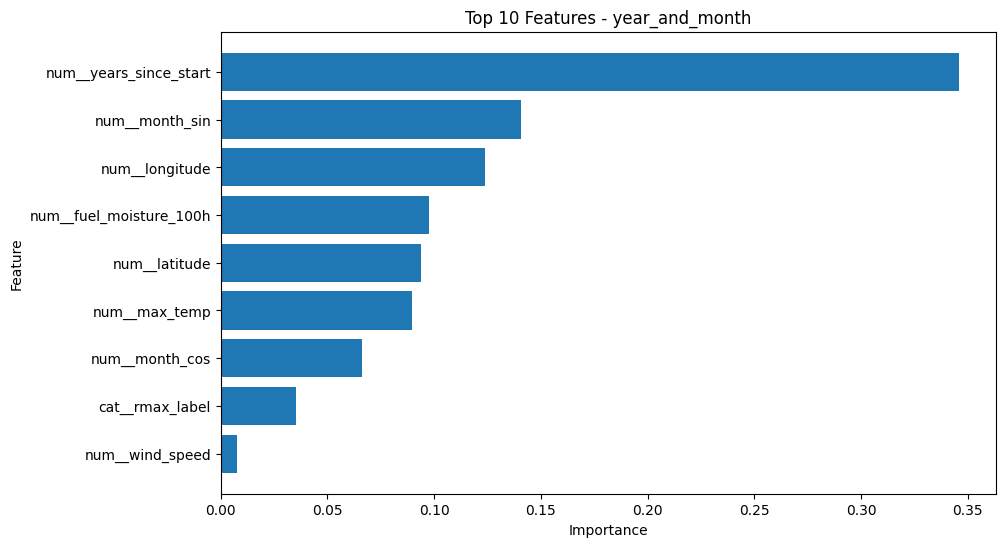

💾 Model saved as year_and_month.pkl.gz

🧪 Running experiment: month_only
  - use_year=False, use_month=True
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:26:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🏆 Best Hyperparameters: {'model__subsample': 1, 'model__n_estimators': 150, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1}

📊 Evaluation Metrics
  accuracy: 0.5678
 precision: 0.8400
    recall: 0.5696
   roc_auc: 0.6031


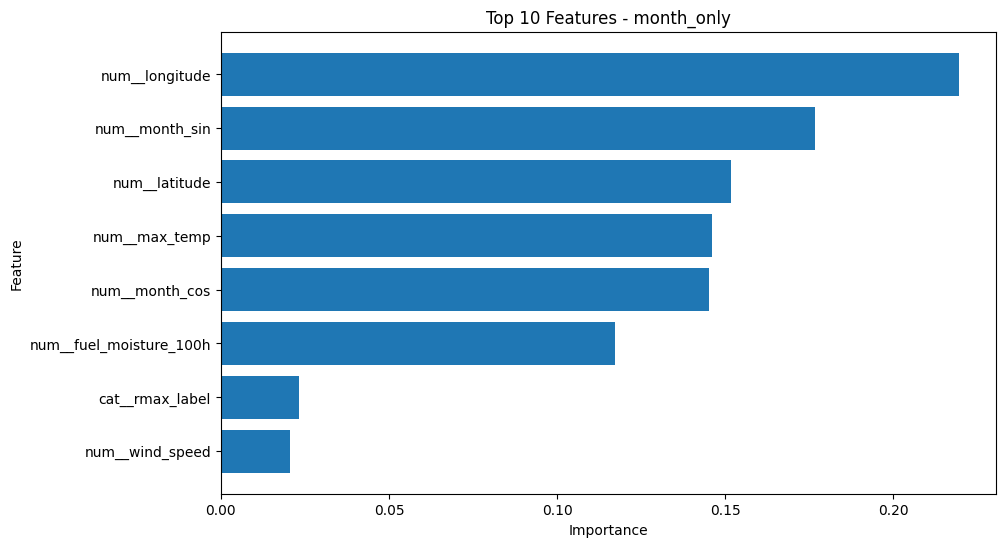

💾 Model saved as month_only.pkl.gz

🧪 Running experiment: year_only
  - use_year=True, use_month=False
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:28:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🏆 Best Hyperparameters: {'model__subsample': 1, 'model__n_estimators': 150, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1}

📊 Evaluation Metrics
  accuracy: 0.7973
 precision: 0.8236
    recall: 0.9510
   roc_auc: 0.5824


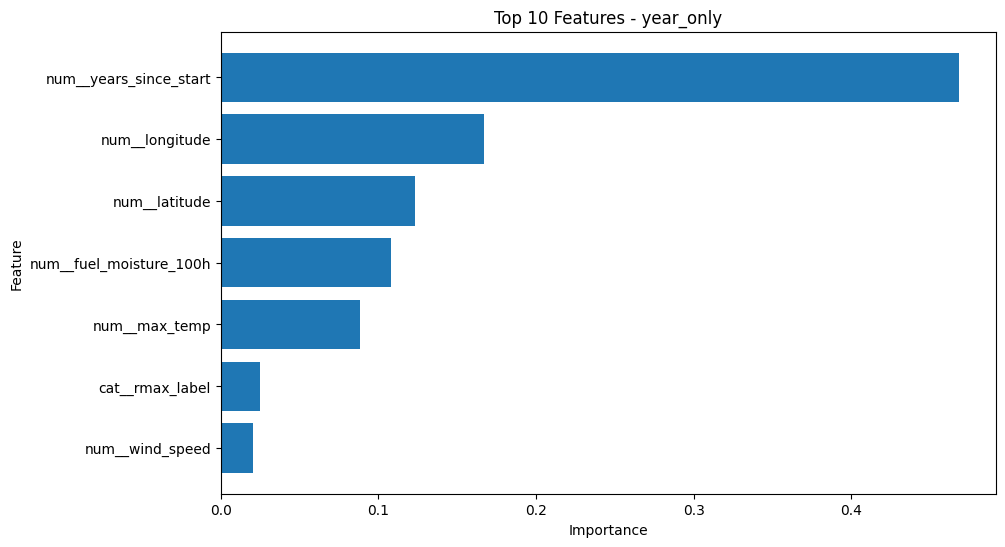

💾 Model saved as year_only.pkl.gz

🧪 Running experiment: no_time_features
  - use_year=False, use_month=False
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:29:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🏆 Best Hyperparameters: {'model__subsample': 1, 'model__n_estimators': 150, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1}

📊 Evaluation Metrics
  accuracy: 0.5198
 precision: 0.8330
    recall: 0.5020
   roc_auc: 0.5832


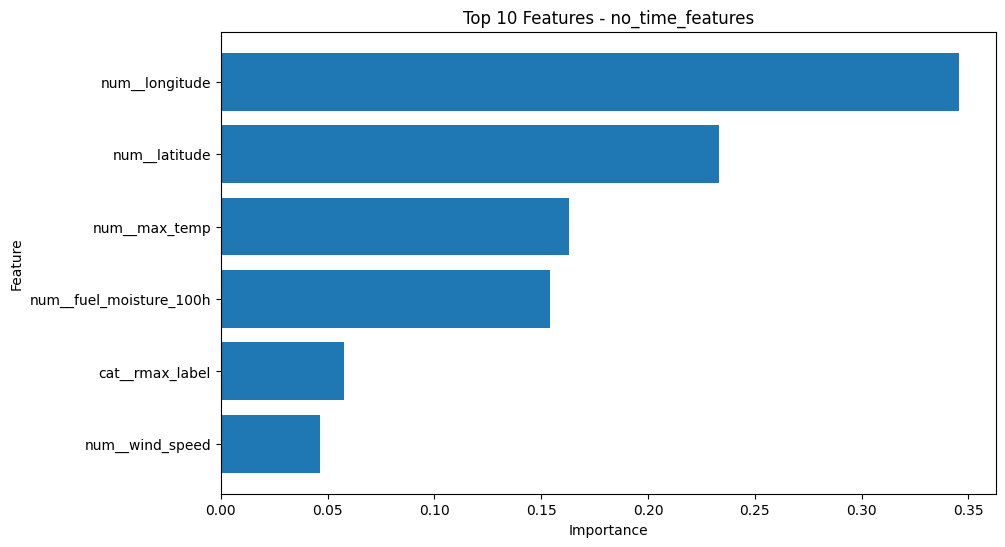

💾 Model saved as no_time_features.pkl.gz

🏁 Summary of All Experiments
         experiment  accuracy  precision    recall   roc_auc
0    year_and_month  0.792839   0.827181  0.937629  0.609291
1        month_only  0.567754   0.840050  0.569574  0.603057
2         year_only  0.797283   0.823567  0.951010  0.582443
3  no_time_features  0.519794   0.832972  0.501993  0.583230


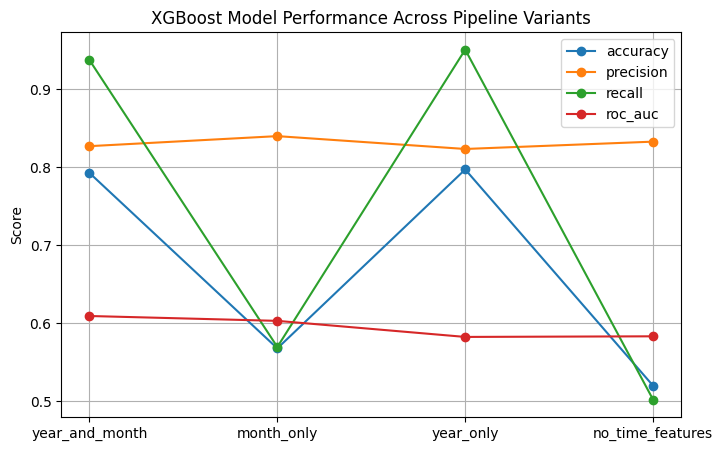

In [9]:
# ============================
# Wildfire XGBoost Experiments with Hyperparameter Tuning
# ============================

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb

# ---------------------------
# 1. Load Data
# ---------------------------
df = pd.read_parquet("/content/wildfire_data.parquet")
target = "Wildfire"

# Rename columns
df = df.rename(columns={
    'datetime': 'date',
    'tmmx': 'max_temp',
    'vs': 'wind_speed',
    'fm100': 'fuel_moisture_100h'
})

# Features
num_features = ['latitude', 'longitude', 'max_temp', 'wind_speed', 'fuel_moisture_100h']
cat_features = ['rmax_label']

# ---------------------------
# 1b. Balanced Sampling for Rare Wildfires
# ---------------------------
df_1 = df[df[target] == 1]
df_0 = df[df[target] == 0].sample(n=len(df_1), random_state=42)  # equal number of 0s
df_balanced = pd.concat([df_1, df_0]).sample(frac=1, random_state=42)  # shuffle

# ---------------------------
# 2. Temporal Split
# ---------------------------
df_balanced['date'] = pd.to_datetime(df_balanced['date'])
last_year = df_balanced['date'].dt.year.max()
second_last_year = last_year - 1

train_df = df_balanced[df_balanced['date'].dt.year < second_last_year]
test_df  = df_balanced[df_balanced['date'].dt.year >= second_last_year]

X_train = train_df[num_features + cat_features + ['date']]
y_train = train_df[target]
X_test = test_df[num_features + cat_features + ['date']]
y_test = test_df[target]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ---------------------------
# 3. Custom Transformer
# ---------------------------
class TimeFeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_col="date", use_year=True, use_month=True):
        self.datetime_col = datetime_col
        self.use_year = use_year
        self.use_month = use_month
        self.min_year = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        if self.use_year and self.datetime_col in X.columns:
            self.min_year = pd.to_datetime(X[self.datetime_col]).dt.year.min()
        self.non_datetime_features = [col for col in X.columns if col != self.datetime_col]
        return self

    def transform(self, X):
        Xt = X.copy()
        dates = pd.to_datetime(Xt[self.datetime_col])
        new_features = []

        if self.use_month:
            months = dates.dt.month
            Xt['month_sin'] = np.sin(2 * np.pi * months / 12)
            Xt['month_cos'] = np.cos(2 * np.pi * months / 12)
            new_features.extend(['month_sin', 'month_cos'])

        if self.use_year:
            years = dates.dt.year
            Xt['years_since_start'] = years - self.min_year
            new_features.append('years_since_start')

        Xt = Xt.drop(columns=[self.datetime_col])
        self.feature_names_out_ = self.non_datetime_features + new_features
        return Xt[self.feature_names_out_]

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_out_ is None:
            raise RuntimeError("fit must be called before get_feature_names_out.")
        return self.feature_names_out_

# ---------------------------
# 4. Experiment Runner with XGBoost
# ---------------------------
def run_experiment(X_train, y_train, X_val, y_val,
                   use_year=True, use_month=True,
                   experiment_name=None, save_model=True,
                   hyperparam_tuning=True):

    if experiment_name is None:
        experiment_name = f"xgb_wildfire_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    print(f"\n🧪 Running experiment: {experiment_name}")
    print(f"  - use_year={use_year}, use_month={use_month}")

    humidity_order = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

    num_pipeline = Pipeline([
        ("time_feats", TimeFeaturesAdder(datetime_col='date', use_year=use_year, use_month=use_month)),
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(categories=[humidity_order]))
    ])

    num_features_with_date = num_features + ['date']
    preprocess = ColumnTransformer([
        ("num", num_pipeline, num_features_with_date),
        ("cat", cat_pipeline, cat_features)
    ])

    pipeline = Pipeline([
        ("preprocess", preprocess),
        ("model", xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            use_label_encoder=False,
            tree_method='hist',         # use histogram algorithm
            predictor='gpu_predictor',  # use GPU
            random_state=42
        ))
    ])


    # ---------------------------
    # Hyperparameter Tuning
    # ---------------------------
    if hyperparam_tuning:
        param_grid = {
            'model__n_estimators': [100, 150],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.05, 0.1],
            'model__subsample': [0.7, 1],
            'model__colsample_bytree': [0.7, 1]
        }

        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grid,
            n_iter=5,
            scoring='roc_auc',
            cv=3,
            verbose=2,
            n_jobs=-1,
            random_state=42
        )

        search.fit(X_train, y_train)
        best_pipeline = search.best_estimator_
        print(f"\n🏆 Best Hyperparameters: {search.best_params_}")
    else:
        best_pipeline = pipeline
        best_pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = best_pipeline.predict(X_val)
    y_proba = best_pipeline.predict_proba(X_val)[:, 1]

    # Metrics
    results = {
        "experiment": experiment_name,
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred),
        "recall": recall_score(y_val, y_pred),
        "roc_auc": roc_auc_score(y_val, y_proba)
    }

    print("\n📊 Evaluation Metrics")
    for k, v in results.items():
        if k != "experiment":
            print(f"{k:>10}: {v:.4f}")

    # Feature importance
    xgb_model = best_pipeline.named_steps['model']
    preprocess_fitted = best_pipeline.named_steps['preprocess']
    feature_names = preprocess_fitted.get_feature_names_out()
    feat_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': xgb_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10,6))
    plt.barh(feat_importance_df['Feature'][:10], feat_importance_df['Importance'][:10])
    plt.gca().invert_yaxis()
    plt.title(f"Top 10 Features - {experiment_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

    # Save model
    if save_model:
        model_path = f"{experiment_name}.pkl.gz"
        joblib.dump(best_pipeline, model_path, compress=3)
        print(f"💾 Model saved as {model_path}")

    return results, feat_importance_df

# ---------------------------
# 5. Run Multiple Variants
# ---------------------------
experiments = [
    {"use_year": True, "use_month": True, "name": "year_and_month"},
    {"use_year": False, "use_month": True, "name": "month_only"},
    {"use_year": True, "use_month": False, "name": "year_only"},
    {"use_year": False, "use_month": False, "name": "no_time_features"},
]

results_all = []
for exp in experiments:
    res, feat_df = run_experiment(
        X_train, y_train, X_test, y_test,
        use_year=exp["use_year"],
        use_month=exp["use_month"],
        experiment_name=exp["name"],
        hyperparam_tuning=True
    )
    results_all.append(res)

# ---------------------------
# 6. Compare Results
# ---------------------------
results_df = pd.DataFrame(results_all)
print("\n🏁 Summary of All Experiments")
print(results_df)

plt.figure(figsize=(8,5))
for metric in ["accuracy", "precision", "recall", "roc_auc"]:
    plt.plot(results_df["experiment"], results_df[metric], marker='o', label=metric)
plt.title("XGBoost Model Performance Across Pipeline Variants")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()